# SkyMapper PHOTOMETRY Import

- Author: Melissa
- Last Run Date: May 12 (not successful yet)
- Issue: https://github.com/astronomy-commons/data.lsdb.io/issues/63



In [26]:
import pandas as pd

import hats_import.pipeline as runner
from hats_import.catalog.arguments import ImportArguments
from hats_import.catalog.file_readers import CsvReader
import pyarrow as pa
import pyarrow.parquet as pq
import os
import hats_import
from pathlib import Path
from dask.distributed import Client
from tqdm import tqdm

In [4]:
hats_import.__version__

'0.5.0'

We pull the types from the published table metadata: https://skymapper.anu.edu.au/table-browser/

This is necessary as some columns are sparse and runs into [known limitations in the import pipeline](https://hats-import.readthedocs.io/en/latest/notebooks/unequal_schema.html).

In [5]:
## List all of our columns as pyarrow fields.
schema_from_pyarrow = pa.schema(
    [
pa.field('object_id', pa.int64()),
pa.field('image_id', pa.int64()),
pa.field('ccd', pa.int32()),
pa.field('ra_img', pa.float64()),
pa.field('decl_img', pa.float64()),
pa.field('x_img', pa.float64(), nullable=True),
pa.field('y_img', pa.float64(), nullable=True),
pa.field('flags', pa.int32(), nullable=True),
pa.field('nimaflags', pa.int64(), nullable=True),
pa.field('background', pa.float64(), nullable=True),
pa.field('flux_max', pa.float64(), nullable=True),
pa.field('mu_max', pa.float64(), nullable=True),
pa.field('class_star', pa.float64(), nullable=True),
pa.field('a', pa.float64(), nullable=True),
pa.field('e_a', pa.float64(), nullable=True),
pa.field('b', pa.float64(), nullable=True),
pa.field('e_b', pa.float64(), nullable=True),
pa.field('pa', pa.float64(), nullable=True),
pa.field('e_pa', pa.float64(), nullable=True),
pa.field('elong', pa.float64(), nullable=True),
pa.field('fwhm', pa.float64(), nullable=True),
pa.field('radius_petro', pa.float64(), nullable=True),
pa.field('radius_kron', pa.float64(), nullable=True),
pa.field('radius_frac20', pa.float64(), nullable=True),
pa.field('radius_frac50', pa.float64(), nullable=True),
pa.field('radius_frac90', pa.float64(), nullable=True),
pa.field('flux_petro', pa.float64(), nullable=True),
pa.field('e_flux_petro', pa.float64(), nullable=True),
pa.field('mag_petro', pa.float64(), nullable=True),
pa.field('e_mag_petro', pa.float64(), nullable=True),
pa.field('flux_kron', pa.float64(), nullable=True),
pa.field('e_flux_kron', pa.float64(), nullable=True),
pa.field('mag_kron', pa.float64(), nullable=True),
pa.field('e_mag_kron', pa.float64(), nullable=True),
pa.field('flux_ap02', pa.float64(), nullable=True),
pa.field('e_flux_ap02', pa.float64(), nullable=True),
pa.field('mag_apc02', pa.float64(), nullable=True),
pa.field('e_mag_apc02', pa.float64(), nullable=True),
pa.field('flux_ap03', pa.float64(), nullable=True),
pa.field('e_flux_ap03', pa.float64(), nullable=True),
pa.field('mag_apc03', pa.float64(), nullable=True),
pa.field('e_mag_apc03', pa.float64(), nullable=True),
pa.field('flux_ap04', pa.float64(), nullable=True),
pa.field('e_flux_ap04', pa.float64(), nullable=True),
pa.field('mag_apc04', pa.float64(), nullable=True),
pa.field('e_mag_apc04', pa.float64(), nullable=True),
pa.field('flux_ap05', pa.float64(), nullable=True),
pa.field('e_flux_ap05', pa.float64(), nullable=True),
pa.field('mag_apc05', pa.float64(), nullable=True),
pa.field('e_mag_apc05', pa.float64(), nullable=True),
pa.field('flux_ap06', pa.float64(), nullable=True),
pa.field('e_flux_ap06', pa.float64(), nullable=True),
pa.field('mag_apc06', pa.float64(), nullable=True),
pa.field('e_mag_apc06', pa.float64(), nullable=True),
pa.field('flux_ap08', pa.float64(), nullable=True),
pa.field('e_flux_ap08', pa.float64(), nullable=True),
pa.field('mag_apc08', pa.float64(), nullable=True),
pa.field('e_mag_apc08', pa.float64(), nullable=True),
pa.field('flux_ap10', pa.float64(), nullable=True),
pa.field('e_flux_ap10', pa.float64(), nullable=True),
pa.field('mag_apc10', pa.float64(), nullable=True),
pa.field('e_mag_apc10', pa.float64(), nullable=True),
pa.field('flux_ap15', pa.float64(), nullable=True),
pa.field('e_flux_ap15', pa.float64(), nullable=True),
pa.field('mag_apr15', pa.float64(), nullable=True),
pa.field('e_mag_apr15', pa.float64(), nullable=True),
pa.field('flux_ap20', pa.float64(), nullable=True),
pa.field('e_flux_ap20', pa.float64(), nullable=True),
pa.field('mag_apr20', pa.float64(), nullable=True),
pa.field('e_mag_apr20', pa.float64(), nullable=True),
pa.field('flux_ap30', pa.float64(), nullable=True),
pa.field('e_flux_ap30', pa.float64(), nullable=True),
pa.field('mag_apr30', pa.float64(), nullable=True),
pa.field('e_mag_apr30', pa.float64(), nullable=True),
pa.field('imaflags', pa.int64(), nullable=True),
pa.field('x_mosaic', pa.float64(), nullable=True),
pa.field('y_mosaic', pa.float64(), nullable=True),
pa.field('chi2_psf', pa.float64(), nullable=True),
pa.field('flux_psf', pa.float64(), nullable=True),
pa.field('e_flux_psf', pa.float64(), nullable=True),
pa.field('mag_psf', pa.float64(), nullable=True),
pa.field('e_mag_psf', pa.float64(), nullable=True),
pa.field('filter', pa.string()),
pa.field('img_qual', pa.int32(), nullable=True),
pa.field('use_in_clipped', pa.int32(), nullable=True),
pa.field('object_id_local', pa.int64(), nullable=True),
    ]
)
schema_file = os.path.join("/data3/epyc/data3/hats/raw/skymapper/", "photo_schema_from_pyarrow.parquet")
pq.write_metadata(schema_from_pyarrow, schema_file)

In [27]:
from csv_pyarrow import CsvPyarrowReader
from pyarrow import csv
import pyarrow as pa
import pyarrow.parquet as pq

with Client(
        local_directory="/data3/epyc/data3/hats/tmp/",
        n_workers=5,
        threads_per_worker=1,
    ) as client:
    args = ImportArguments(
        output_artifact_name="photometry",
        input_file_list=list(Path("/data3/epyc/data3/hats/raw/skymapper/photometry").glob("SkyMapper.DR4.pho*.csv.gz")),
        file_reader=CsvPyarrowReader(convert_options = csv.ConvertOptions(column_types = schema_from_pyarrow)),
        ra_column="ra_img",
        dec_column="decl_img",
        pixel_threshold=2_000_000,
        resume=False,
        drop_empty_siblings=True,
        output_path="/data3/epyc/data3/hats/skymapper/",
        simple_progress_bar=True,
        use_schema_file=schema_file,
        completion_email_address="delucchi@andrew.cmu.edu",
    )
    runner.pipeline_with_client(args, client)

/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38273 instead
  warnings.warn(
Reducing  :   9%|▊         | 1396/16260 [1:00:22<11:28:24,  2.78s/it]2025-05-14 11:38:56,944 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:38837' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'reduce_pixel_shards-139264ecacde20723db2c7c690893344', 'reduce_pixel_shards-c038a93d06acd77964fd1ff661ba81c5', 'reduce_pixel_shards-ade76d91dfc492358d16e4f135baaad3', 'reduce_pixel_shards-4539a7dc044692d45d64305808a0f32e', 'reduce_pixel_shards-7de941c73daac33f70c1a88170d078bd', 'reduce_pixel_shards-4ee18b351addf5b7bac750a44d427b92', 'reduce_pixel_shards-ccab39bbd98364e15005247a3b623b14', 'reduce_pixel_shards-775d29604ea1c385597ee83ada1fb06d', 'reduce_pixel_shards-2aa7cb2789379f55dd2d836992d8e9

2025-05-14 11:38:57,055 - distributed.nanny - WARNING - Restarting worker
Reducing  :   9%|▊         | 1399/16260 [1:00:35<14:23:55,  3.49s/it]

Failed REDUCING stage for shard: 6 29216
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29216


2025-05-14 11:39:08,717 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e28024aaa2bbc78ede73c7eeb081838d
State:     executing
Task:  <Task 'reduce_pixel_shards-e28024aaa2bbc78ede73c7eeb081838d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29216')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 9 1912150
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1910000/pixel_1912150
Failed REDUCING stage for shard: 7 116690
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_116690
Failed REDUCING stage for shard: 6 31081
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_31081
Failed REDUCING stage for shard: 6 41927
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41927
Failed REDUCING stage for shard: 6 21511
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21511
Failed REDUCING stage for shard: 6 47780
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_4

2025-05-14 11:39:08,926 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-55015c0c8a50f79a6a89e22f046fce5b
State:     executing
Task:  <Task 'reduce_pixel_shards-55015c0c8a50f79a6a89e22f046fce5b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1840000/pixel_1847532')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^

/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1840000/pixel_1847532
Failed REDUCING stage for shard: 7 116382
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_116382
Failed REDUCING stage for shard: 6 43834
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43834
Failed REDUCING stage for shard: 6 29834
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29834
Failed REDUCING stage for shard: 4 2929
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2929
Failed REDUCING stage for shard: 5 6564
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6564
Failed REDUCING stage for shard: 6 41727
  worker address: tcp://127.0.0.1:382

^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1371, in __init__\n    self._dataset = ds.dataset(path_or_paths, filesystem=filesystem,\n                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/dataset.py", line 794, in dataset\n    return _filesystem_dataset(source, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/dataset.py", line 476, in _filesystem_dataset\n    fs, paths_or_selector = _ensure_single_source(source, filesystem)\n                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/dataset.py", line 441, in _ensure_single_source\n    raise FileNotFoundError(path)\n'

2025-05-14 11:39:09,137 - distributed.worker - ERROR - Compute F

Failed REDUCING stage for shard: 5 11020
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11020
Failed REDUCING stage for shard: 4 2016
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2016
Failed REDUCING stage for shard: 6 41982
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41982
Failed REDUCING stage for shard: 6 29216
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29216
Failed REDUCING stage for shard: 9 1912150
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1910000/pixel_1912150
Failed REDUCING stage for shard: 7 116690
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pi

2025-05-14 11:39:09,334 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-67ef6ac7ee0ff59ef574f6806f41fafe
State:     executing
Task:  <Task 'reduce_pixel_shards-67ef6ac7ee0ff59ef574f6806f41fafe' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842524')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

Failed REDUCING stage for shard: 7 115014
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115014
Failed REDUCING stage for shard: 7 191417
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_190000/pixel_191417
Failed REDUCING stage for shard: 8 344044
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_340000/pixel_344044
Failed REDUCING stage for shard: 7 117108
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_117108
Failed REDUCING stage for shard: 6 42345
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42345
Failed REDUCING stage for shard: 6 21700
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/di

2025-05-14 11:39:09,544 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-0cb05840802f04127067ae77f5a405f1
State:     executing
Task:  <Task 'reduce_pixel_shards-0cb05840802f04127067ae77f5a405f1' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_150000/pixel_151766')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

2025-05-14 11:39:09,748 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-fa6e804cdfe7e0e9f0af33288d460c82
State:     executing
Task:  <Task 'reduce_pixel_shards-fa6e804cdfe7e0e9f0af33288d460c82' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41916')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 41916
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41916
Failed REDUCING stage for shard: 10 10843250
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843250
Failed REDUCING stage for shard: 6 42963
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42963
Failed REDUCING stage for shard: 6 41795
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41795
Failed REDUCING stage for shard: 5 9665
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9665
Failed REDUCING stage for shard: 10 10837760
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_

2025-05-14 11:39:09,956 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-71b51512777de5c2be36e9cd42a21f79
State:     executing
Task:  <Task 'reduce_pixel_shards-71b51512777de5c2be36e9cd42a21f79' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11330')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 11:39:10,158 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-bde3a2c8f9df1c826c78240f24143151
State:     executing
Task:  <Task 'reduce_pixel_shards-bde3a2c8f9df1c826c78240f24143151' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6566')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 5 6566
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6566
Failed REDUCING stage for shard: 6 19098
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_10000/pixel_19098
Failed REDUCING stage for shard: 5 9599
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9599
Failed REDUCING stage for shard: 6 40561
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_40561
Failed REDUCING stage for shard: 6 37178
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37178
Failed REDUCING stage for shard: 7 184143
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_180000/pixel_184143
F

2025-05-14 11:39:10,365 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-33b65d21dfeb4e45b28ddf338988dc2c
State:     executing
Task:  <Task 'reduce_pixel_shards-33b65d21dfeb4e45b28ddf338988dc2c' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43273')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 10 10837641
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837641
Failed REDUCING stage for shard: 6 28723
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_28723
Failed REDUCING stage for shard: 5 5224
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5224

  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6566
Failed REDUCING stage for shard: 6 19098
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_10000/pixel_19098
Failed REDUCING stage for shard: 5 9599
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9599
Failed REDUCING stage for shard: 6 405

2025-05-14 11:39:10,582 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-7f104232065ceb352f2fcbc4c2e4a784
State:     executing
Task:  <Task 'reduce_pixel_shards-7f104232065ceb352f2fcbc4c2e4a784' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837641')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

Failed REDUCING stage for shard: 10 10837520
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837520
Failed REDUCING stage for shard: 5 6500
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6500
Failed REDUCING stage for shard: 4 1697
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1697
Failed REDUCING stage for shard: 5 3117
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_3117
Failed REDUCING stage for shard: 7 138707
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_130000/pixel_138707
Failed REDUCING stage for shard: 6 40495
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_40

2025-05-14 11:39:11,115 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-42b4503bacb6abf2c998e0be2dbd6c17
State:     executing
Task:  <Task 'reduce_pixel_shards-42b4503bacb6abf2c998e0be2dbd6c17' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_12045')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 5 9709
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9709
Failed REDUCING stage for shard: 6 29825
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29825
Failed REDUCING stage for shard: 7 151715
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_150000/pixel_151715
Failed REDUCING stage for shard: 7 116252
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_116252
Failed REDUCING stage for shard: 7 169206
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169206
Failed REDUCING stage for shard: 6 41489
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/p

2025-05-14 11:39:11,321 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-8729dc3e243c8bd593cdec3bf645b45f
State:     executing
Task:  <Task 'reduce_pixel_shards-8729dc3e243c8bd593cdec3bf645b45f' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169703')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

Failed REDUCING stage for shard: 8 649166
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_640000/pixel_649166
Failed REDUCING stage for shard: 6 41865
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41865
Failed REDUCING stage for shard: 10 10836783
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836783
Failed REDUCING stage for shard: 10 10843428
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843428
Failed REDUCING stage for shard: 6 30080
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_30080
Failed REDUCING stage for shard: 5 6810
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediat

Reducing  :   9%|▊         | 1401/16260 [1:00:41<13:50:31,  3.35s/it]2025-05-14 11:39:13,977 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-ee91332566876989419af9d25076fe10
State:     executing
Task:  <Task 'reduce_pixel_shards-ee91332566876989419af9d25076fe10' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43095')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, i

Failed REDUCING stage for shard: 6 43095
  worker address: tcp://127.0.0.1:34588
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43095


Reducing  :   9%|▊         | 1405/16260 [1:00:52<11:30:01,  2.79s/it]2025-05-14 11:39:24,914 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-fd0ab652efcc3b41de87cf19c4b9c3be
State:     executing
Task:  <Task 'reduce_pixel_shards-fd0ab652efcc3b41de87cf19c4b9c3be' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836966')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 

Failed REDUCING stage for shard: 10 10836966
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836966


Reducing  :   9%|▊         | 1421/16260 [1:01:35<11:23:27,  2.76s/it]2025-05-14 11:40:07,476 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-880ae15b7b208c170be9f4cd893a6fbf
State:     executing
Task:  <Task 'reduce_pixel_shards-880ae15b7b208c170be9f4cd893a6fbf' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_162253')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793,

Failed REDUCING stage for shard: 7 162253
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_162253
Failed REDUCING stage for shard: 6 47826
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47826
Failed REDUCING stage for shard: 7 115005
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115005
Failed REDUCING stage for shard: 7 169716
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169716
Failed REDUCING stage for shard: 6 35812
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_35812
Failed REDUCING stage for shard: 4 1094
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/

Reducing  :   9%|▊         | 1422/16260 [1:01:37<10:58:19,  2.66s/it]2025-05-14 11:40:09,862 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-2b8ec433b9fb66962552a1c3fd11952d
State:     executing
Task:  <Task 'reduce_pixel_shards-2b8ec433b9fb66962552a1c3fd11952d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1444')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in rea

Failed REDUCING stage for shard: 4 1444
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1444


Reducing  :   9%|▉         | 1423/16260 [1:01:39<10:02:06,  2.43s/it]2025-05-14 11:40:11,856 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-4c77509389b1672951dcb6e37468174b
State:     executing
Task:  <Task 'reduce_pixel_shards-4c77509389b1672951dcb6e37468174b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_117112')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793,

Failed REDUCING stage for shard: 7 117112
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_117112


Reducing  :  15%|█▍        | 2364/16260 [1:49:40<15:00:01,  3.89s/it]2025-05-14 12:28:14,801 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:34588' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'reduce_pixel_shards-b3c12f49e8d72fe833a53ded47686ddb', 'reduce_pixel_shards-f641e6c831c2a4027161077a18e692f8', 'reduce_pixel_shards-6226364fa66e93adbac9e8baf889ef9c', 'reduce_pixel_shards-e5999d52bd02f2f5b9a97be7caabe267', 'reduce_pixel_shards-9098b206a0c1377cdab9014d3bbab8f8', 'reduce_pixel_shards-82dbbb45644baa6a931015a2856e8f18', 'reduce_pixel_shards-18249905dcc0f2202987fb3a23a1a6fe', 'reduce_pixel_shards-fbaf09c1191dd6213a059e8ce04a356f', 'reduce_pixel_shards-e1b01dd32ac497cb669650eef2875003', 'reduce_pixel_shards-120e06da7b5efef50cbe86497a1f97bd', 'reduce_pixel_shards-fb06b99561aadad9a1835d6ef15e20d6', 'reduce_pixel_shards-06157f848cf238f3c4f36b55288b7c3e', 'reduce_pixel_shards-31dc1f3412cb4570258bbc33079337fa', 'reduce_pixel

2025-05-14 12:28:14,985 - distributed.nanny - WARNING - Restarting worker
Reducing  :  15%|█▍        | 2367/16260 [1:49:55<15:34:08,  4.03s/it]2025-05-14 12:28:27,351 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-9df3081688792114e291d707361275ba
State:     executing
Task:  <Task 'reduce_pixel_shards-9df3081688792114e291d707361275ba' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842214')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda

Failed REDUCING stage for shard: 10 10842214
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842214
Failed REDUCING stage for shard: 6 37726
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37726
Failed REDUCING stage for shard: 10 10843261
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843261
Failed REDUCING stage for shard: 5 7811
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_7811
Failed REDUCING stage for shard: 6 41364
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41364
Failed REDUCING stage for shard: 9 1847895
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/orde

2025-05-14 12:28:27,545 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-c853347f9747cb2a22dc44fd93fd1cae
State:     executing
Task:  <Task 'reduce_pixel_shards-c853347f9747cb2a22dc44fd93fd1cae' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47914')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 47914
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47914
Failed REDUCING stage for shard: 6 19096
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_10000/pixel_19096
Failed REDUCING stage for shard: 6 29713
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29713
Failed REDUCING stage for shard: 5 6214
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6214
Failed REDUCING stage for shard: 6 41606
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41606
Failed REDUCING stage for shard: 10 10842711
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pi

2025-05-14 12:28:27,751 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-88d7472ed9526608f8c7815efaffe75b
State:     executing
Task:  <Task 'reduce_pixel_shards-88d7472ed9526608f8c7815efaffe75b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1453')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Reducing  :  15%|█▍        | 2368/16260 [1:49:55<11:35:28,  3.00s/it]2025-05-14 12:28:27,933 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-10b76022753b12d1da82ca07699379b8
State:     executing
Task:  <Task 'reduce_pixel_shards-10b76022753b12d1da82ca07699379b8' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_461858')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793,

Failed REDUCING stage for shard: 7 114785
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_114785
Failed REDUCING stage for shard: 4 2271
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2271
Failed REDUCING stage for shard: 10 10837155
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837155
Failed REDUCING stage for shard: 6 41298
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41298
Failed REDUCING stage for shard: 6 37915
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37915
Failed REDUCING stage for shard: 7 115940
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_1

2025-05-14 12:28:27,963 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-59ad0e72b91ad4da799f8c0e15276b0d
State:     executing
Task:  <Task 'reduce_pixel_shards-59ad0e72b91ad4da799f8c0e15276b0d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11196')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:28,134 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-f559ca9d4f9a2f231dea9bfeeb536770
State:     executing
Task:  <Task 'reduce_pixel_shards-f559ca9d4f9a2f231dea9bfeeb536770' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43823')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 41929
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41929
Failed REDUCING stage for shard: 10 10836847
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836847
Failed REDUCING stage for shard: 6 43205
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43205
Failed REDUCING stage for shard: 5 11075
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11075
Failed REDUCING stage for shard: 6 42037
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42037
Failed REDUCING stage for shard: 7 115632
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/di

2025-05-14 12:28:28,166 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-622119678a20a041a66ff22e4f491fbe
State:     executing
Task:  <Task 'reduce_pixel_shards-622119678a20a041a66ff22e4f491fbe' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_166760')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

2025-05-14 12:28:28,345 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-444ba2d988b5b707360af52344b5a35e
State:     executing
Task:  <Task 'reduce_pixel_shards-444ba2d988b5b707360af52344b5a35e' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_121243')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

Failed REDUCING stage for shard: 6 39272
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_39272
Failed REDUCING stage for shard: 6 38104
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38104
Failed REDUCING stage for shard: 6 22118
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_22118
Failed REDUCING stage for shard: 6 41366
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41366
Failed REDUCING stage for shard: 7 114961
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_114961
Failed REDUCING stage for shard: 6 29352
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/p

2025-05-14 12:28:28,369 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-848a1348485bf84080199933ea652a7d
State:     executing
Task:  <Task 'reduce_pixel_shards-848a1348485bf84080199933ea652a7d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11130')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:28,549 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-9a97ec99dbb7db43bd97656ad23fc43c
State:     executing
Task:  <Task 'reduce_pixel_shards-9a97ec99dbb7db43bd97656ad23fc43c' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_190000/pixel_191419')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

Failed REDUCING stage for shard: 6 39877
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_39877

Failed REDUCING stage for shard: 6 41929
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41929
Failed REDUCING stage for shard: 10 10836847
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836847
Failed REDUCING stage for shard: 6 43205
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43205
Failed REDUCING stage for shard: 5 11075
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11075
Failed REDUCING stage for shard: 6 42037
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/di

2025-05-14 12:28:28,576 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-407f3aedc4b9960651a690af70fbda6a
State:     executing
Task:  <Task 'reduce_pixel_shards-407f3aedc4b9960651a690af70fbda6a' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842513')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

2025-05-14 12:28:28,752 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-f89556736dc6049aaac718f2de26934d
State:     executing
Task:  <Task 'reduce_pixel_shards-f89556736dc6049aaac718f2de26934d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_7681')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 6 37796
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37796
Failed REDUCING stage for shard: 6 38025
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38025
Failed REDUCING stage for shard: 5 10096
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10096
Failed REDUCING stage for shard: 4 1092
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1092
Failed REDUCING stage for shard: 6 47703
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47703
Failed REDUCING stage for shard: 4 2139
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2139
Fail

2025-05-14 12:28:28,787 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-39b22afde9903f7c9a5349de32102312
State:     executing
Task:  <Task 'reduce_pixel_shards-39b22afde9903f7c9a5349de32102312' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_31059')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:28,953 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-982a4581554988d4e7035e87a09ccac1
State:     executing
Task:  <Task 'reduce_pixel_shards-982a4581554988d4e7035e87a09ccac1' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_30388')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 37475
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37475
Failed REDUCING stage for shard: 5 5345
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5345

Failed REDUCING stage for shard: 7 116734
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_116734
Failed REDUCING stage for shard: 6 41742
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41742
Failed REDUCING stage for shard: 10 10843076
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843076
Failed REDUCING stage for shard: 5 12056
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_1

2025-05-14 12:28:28,998 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-31dc1f3412cb4570258bbc33079337fa
State:     executing
Task:  <Task 'reduce_pixel_shards-31dc1f3412cb4570258bbc33079337fa' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4782')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

2025-05-14 12:28:29,160 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-ac1e7eab02a3870a05785fefbd20958b
State:     executing
Task:  <Task 'reduce_pixel_shards-ac1e7eab02a3870a05785fefbd20958b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11453')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4782
Failed REDUCING stage for shard: 4 2194
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2194
Failed REDUCING stage for shard: 8 477646
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_470000/pixel_477646
Failed REDUCING stage for shard: 6 21744
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21744
Failed REDUCING stage for shard: 9 1847523
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1840000/pixel_1847523
Failed REDUCING stage for shard: 7 121232
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_121232
Failed REDUCING stage for shard:

2025-05-14 12:28:29,185 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-7a2e0cb586e5bcd63960ae8f4ec4fba4
State:     executing
Task:  <Task 'reduce_pixel_shards-7a2e0cb586e5bcd63960ae8f4ec4fba4' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9346')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

2025-05-14 12:28:29,363 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-2ecd6b52caaeb52f90baab58fda63084
State:     executing
Task:  <Task 'reduce_pixel_shards-2ecd6b52caaeb52f90baab58fda63084' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43409')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 30322
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_30322
Failed REDUCING stage for shard: 6 41168
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41168
Failed REDUCING stage for shard: 5 4608
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4608
Failed REDUCING stage for shard: 7 121179
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_121179
Failed REDUCING stage for shard: 6 41986
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41986
Failed REDUCING stage for shard: 6 42215
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_4

2025-05-14 12:28:29,410 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-2f32f6483284fb4b6926e1719f4b6d37
State:     executing
Task:  <Task 'reduce_pixel_shards-2f32f6483284fb4b6926e1719f4b6d37' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47718')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:29,567 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-ddf7d140570b92cef1fc20127b37290d
State:     executing
Task:  <Task 'reduce_pixel_shards-ddf7d140570b92cef1fc20127b37290d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10945')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 47718
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47718
Failed REDUCING stage for shard: 9 2709493
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_2700000/pixel_2709493
Failed REDUCING stage for shard: 6 21704
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21704
Failed REDUCING stage for shard: 6 36980
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_36980
Failed REDUCING stage for shard: 6 41181
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41181
Failed REDUCING stage for shard: 8 365848
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_360

2025-05-14 12:28:29,619 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-4294542ce3138b912d32fd633383d87f
State:     executing
Task:  <Task 'reduce_pixel_shards-4294542ce3138b912d32fd633383d87f' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836475')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

2025-05-14 12:28:29,784 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-5f7498888834e0fb4818fadb8ed142fa
State:     executing
Task:  <Task 'reduce_pixel_shards-5f7498888834e0fb4818fadb8ed142fa' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_166509')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

Failed REDUCING stage for shard: 6 42954
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42954
Failed REDUCING stage for shard: 10 10836475
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836475
Failed REDUCING stage for shard: 5 7441
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_7441
Failed REDUCING stage for shard: 6 29772
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29772
Failed REDUCING stage for shard: 10 10837522
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837522
Failed REDUCING stage for shard: 10 10837751
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/or

2025-05-14 12:28:29,799 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e677f07f4d93a9ce7a874365b3dbd807
State:     executing
Task:  <Task 'reduce_pixel_shards-e677f07f4d93a9ce7a874365b3dbd807' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11321')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:29,989 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-80ae8194631ce11a9d89c02f9a89d2b5
State:     executing
Task:  <Task 'reduce_pixel_shards-80ae8194631ce11a9d89c02f9a89d2b5' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842396')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

Failed REDUCING stage for shard: 5 4784
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4784
Failed REDUCING stage for shard: 5 11429
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11429
Failed REDUCING stage for shard: 6 37961
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37961
Failed REDUCING stage for shard: 8 677342
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_670000/pixel_677342
Failed REDUCING stage for shard: 6 21746
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21746
Failed REDUCING stage for shard: 6 47639
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_4

2025-05-14 12:28:30,038 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-36c7c151fbf5e82301dd30b9e3283e82
State:     executing
Task:  <Task 'reduce_pixel_shards-36c7c151fbf5e82301dd30b9e3283e82' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21572')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:30,202 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-fb1d199e40c0ab12cef69e1368900585
State:     executing
Task:  <Task 'reduce_pixel_shards-fb1d199e40c0ab12cef69e1368900585' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9711')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 6 21572
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21572
Failed REDUCING stage for shard: 5 10087
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10087
Failed REDUCING stage for shard: 7 166551
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_166551
Failed REDUCING stage for shard: 5 11134
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11134
Failed REDUCING stage for shard: 6 37895
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37895
Failed REDUCING stage for shard: 8 677276
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_670000

2025-05-14 12:28:30,216 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e3789cca185fb7184e624db1f327a760
State:     executing
Task:  <Task 'reduce_pixel_shards-e3789cca185fb7184e624db1f327a760' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_116254')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

2025-05-14 12:28:30,248 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-6cb6d5d6dbec3e29529d6d87064da579
State:     executing
Task:  <Task 'reduce_pixel_shards-6cb6d5d6dbec3e29529d6d87064da579' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1404')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

2025-05-14 12:28:30,410 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-24b8dbf80be0666288f43bf513be374b
State:     executing
Task:  <Task 'reduce_pixel_shards-24b8dbf80be0666288f43bf513be374b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41922')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 4 1404
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1404
Failed REDUCING stage for shard: 4 1633
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1633
Failed REDUCING stage for shard: 7 114965
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_114965
Failed REDUCING stage for shard: 6 42417
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42417
Failed REDUCING stage for shard: 10 10837564
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837564
Failed REDUCING stage for shard: 7 116241
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/

2025-05-14 12:28:30,418 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e000d1ef902f3b4c521ec706d12f2752
State:     executing
Task:  <Task 'reduce_pixel_shards-e000d1ef902f3b4c521ec706d12f2752' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836840')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

2025-05-14 12:28:30,461 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-97ebf27ba522000c22bced748d6a4615
State:     executing
Task:  <Task 'reduce_pixel_shards-97ebf27ba522000c22bced748d6a4615' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42030')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:30,613 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-afff242d5ff1ee17d8072ed0df714371
State:     executing
Task:  <Task 'reduce_pixel_shards-afff242d5ff1ee17d8072ed0df714371' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5336')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 6 42030
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42030
Failed REDUCING stage for shard: 7 191210
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_190000/pixel_191210
Failed REDUCING stage for shard: 5 9900
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9900
Failed REDUCING stage for shard: 9 1912132
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1910000/pixel_1912132
Failed REDUCING stage for shard: 6 43077
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43077
Failed REDUCING stage for shard: 7 169397
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000

2025-05-14 12:28:30,620 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-ba34670628f7934afa96437838ed1e34
State:     executing
Task:  <Task 'reduce_pixel_shards-ba34670628f7934afa96437838ed1e34' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9766')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

2025-05-14 12:28:30,670 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-84c5c1cb37069974f18c353f88ba366b
State:     executing
Task:  <Task 'reduce_pixel_shards-84c5c1cb37069974f18c353f88ba366b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_31747')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:30,818 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-6ab812290e5488099dfa26dd94f20565
State:     executing
Task:  <Task 'reduce_pixel_shards-6ab812290e5488099dfa26dd94f20565' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837942')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41546
Failed REDUCING stage for shard: 6 31747
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_31747
Failed REDUCING stage for shard: 6 42593
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42593
Failed REDUCING stage for shard: 7 120389
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_120389
Failed REDUCING stage for shard: 7 171357
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_170000/pixel_171357
Failed REDUCING stage for shard: 6 48070
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_48070
Failed REDUCING stage for shard: 7 169960
  worker address: tcp://1

2025-05-14 12:28:30,829 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-89672c48e0a9ac23c06ce496b904b1cd
State:     executing
Task:  <Task 'reduce_pixel_shards-89672c48e0a9ac23c06ce496b904b1cd' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10894')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:30,874 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e462aab88cb45df530f843c3c8d3851d
State:     executing
Task:  <Task 'reduce_pixel_shards-e462aab88cb45df530f843c3c8d3851d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1840000/pixel_1847448')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^

2025-05-14 12:28:31,022 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-be8d079cc79fba1eb4098f93061ab3b0
State:     executing
Task:  <Task 'reduce_pixel_shards-be8d079cc79fba1eb4098f93061ab3b0' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43816')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 47333
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47333
Failed REDUCING stage for shard: 9 1847448
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1840000/pixel_1847448
Failed REDUCING stage for shard: 7 116727
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_116727
Failed REDUCING stage for shard: 5 11002
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11002
Failed REDUCING stage for shard: 9 2709108
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_2700000/pixel_2709108
Failed REDUCING stage for shard: 5 7619
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/

2025-05-14 12:28:31,031 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-3da1d069ab08f06cfb329c4df2d4545a
State:     executing
Task:  <Task 'reduce_pixel_shards-3da1d069ab08f06cfb329c4df2d4545a' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_20956')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:31,077 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-40c4b25272da425dc16de1f5fbf7d543
State:     executing
Task:  <Task 'reduce_pixel_shards-40c4b25272da425dc16de1f5fbf7d543' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_39265')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 5 6317
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6317

/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6383
Failed REDUCING stage for shard: 7 169263
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169263
Failed REDUCING stage for shard: 6 41546
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41546
Failed REDUCING stage for shard: 6 31747
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_31747
Failed REDUCING stage for shard: 6 42593
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42593
Failed REDUCING stage for shard: 7 120389
  worker address: tcp://127.0.0.1:3552

2025-05-14 12:28:31,235 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-1892745543e0c574ad77852e7adc60ae
State:     executing
Task:  <Task 'reduce_pixel_shards-1892745543e0c574ad77852e7adc60ae' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42285')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 12:28:31,293 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-c009bbce681ab42e56e29f0e85350e40
State:     executing
Task:  <Task 'reduce_pixel_shards-c009bbce681ab42e56e29f0e85350e40' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2198')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Reducing  :  15%|█▍        | 2369/16260 [1:49:59<12:11:12,  3.16s/it]

Failed REDUCING stage for shard: 7 114941
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_114941
Failed REDUCING stage for shard: 4 2198
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2198
Failed REDUCING stage for shard: 6 42164
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42164
Failed REDUCING stage for shard: 6 21748
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21748
Failed REDUCING stage for shard: 9 2710584
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_2710000/pixel_2710584
Failed REDUCING stage for shard: 10 10842330
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10

2025-05-14 12:28:31,457 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-2600d58e2a795ff4f69c52a85f79b0ea
State:     executing
Task:  <Task 'reduce_pixel_shards-2600d58e2a795ff4f69c52a85f79b0ea' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4778')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 6 39833
  worker address: tcp://127.0.0.1:35094
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_39833
Failed REDUCING stage for shard: 5 5946
  worker address: tcp://127.0.0.1:35094
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5946


2025-05-14 12:28:39,413 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-8a96845e73343aa6d8a340d23eb3eed4
State:     executing
Task:  <Task 'reduce_pixel_shards-8a96845e73343aa6d8a340d23eb3eed4' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_39833')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 42587
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42587


Reducing  :  16%|█▌        | 2550/16260 [1:59:20<13:08:12,  3.45s/it]2025-05-14 12:37:52,906 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-183c2c1097c8a1ccc88534ecac8bcb79
State:     executing
Task:  <Task 'reduce_pixel_shards-183c2c1097c8a1ccc88534ecac8bcb79' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2132')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in rea

Failed REDUCING stage for shard: 4 2132
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2132
Failed REDUCING stage for shard: 6 42098
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42098
Failed REDUCING stage for shard: 6 21682
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21682
Failed REDUCING stage for shard: 7 168647
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_168647
Failed REDUCING stage for shard: 8 649049
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_640000/pixel_649049
Failed REDUCING stage for shard: 7 114754
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pi

Reducing  :  16%|█▌        | 2551/16260 [1:59:27<16:24:25,  4.31s/it]2025-05-14 12:37:59,807 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-43060af822ec9190228bf8bbf71e7306
State:     executing
Task:  <Task 'reduce_pixel_shards-43060af822ec9190228bf8bbf71e7306' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_640000/pixel_649170')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793,

Failed REDUCING stage for shard: 8 649170
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_640000/pixel_649170


Reducing  :  16%|█▌        | 2552/16260 [1:59:29<13:51:38,  3.64s/it]2025-05-14 12:38:01,606 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e1b01dd32ac497cb669650eef2875003
State:     executing
Task:  <Task 'reduce_pixel_shards-e1b01dd32ac497cb669650eef2875003' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_166553')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793,

Failed REDUCING stage for shard: 7 166553
  worker address: tcp://127.0.0.1:35094
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_166553


Reducing  :  38%|███▊      | 6119/16260 [4:54:46<10:42:03,  3.80s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Reducing  :  40%|███▉      | 6476/16260 [5:11:44<6:13:06,  2.29s/it] 2025-05-14 15:50:24,818 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:35094' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'reduce_pixel_shards-b83cc6018b22e44f7f9259293d03f01f', 'reduce_pixel_shards-6ffb07cd60a2f6937297f5b5430db0e5', 'reduce_pixel_shards-ccc5e40f43836f5cbe0fcd13d5e2fc47', 'reduce_pixel_shards-647b5dfbd120428181cdc433ec818912', 'reduce_pixel_shards-461507860310e15abb5a69bc5ad38dd2', 'reduce_pixel_shards-3438e301db49443314bb1d05bcf56403', 'reduce_pix

2025-05-14 15:50:24,995 - distributed.nanny - WARNING - Restarting worker
Reducing  :  40%|███▉      | 6480/16260 [5:12:00<8:08:04,  2.99s/it] 2025-05-14 15:50:32,671 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-71e51dc07dec2207fdd64c6e7ede98e2
State:     executing
Task:  <Task 'reduce_pixel_shards-71e51dc07dec2207fdd64c6e7ede98e2' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11996')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/h

Failed REDUCING stage for shard: 5 11996
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11996
Failed REDUCING stage for shard: 7 169278
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169278
Failed REDUCING stage for shard: 6 41790
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41790
Failed REDUCING stage for shard: 6 21374
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21374
Failed REDUCING stage for shard: 5 11875
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11875
Failed REDUCING stage for shard: 10 10842185
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10

2025-05-14 15:50:32,781 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-d3d814162d7e4074fe0bbd0dae373c41
State:     executing
Task:  <Task 'reduce_pixel_shards-d3d814162d7e4074fe0bbd0dae373c41' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9768')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

2025-05-14 15:50:32,885 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-d85eae7eaad29ad38f34a7ebf33d2b28
State:     executing
Task:  <Task 'reduce_pixel_shards-d85eae7eaad29ad38f34a7ebf33d2b28' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_31749')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 4 1703
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1703
Failed REDUCING stage for shard: 5 9768
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9768
Failed REDUCING stage for shard: 8 461169
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_461169
Failed REDUCING stage for shard: 6 38515
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38515
Failed REDUCING stage for shard: 6 47146
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47146
Failed REDUCING stage for shard: 8 461987
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_46198

2025-05-14 15:50:32,986 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-a47c2c05ffba566222013e702ecb2412
State:     executing
Task:  <Task 'reduce_pixel_shards-a47c2c05ffba566222013e702ecb2412' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41306')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 15:50:33,093 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-577c1b8712e7b68062f289b834578e38
State:     executing
Task:  <Task 'reduce_pixel_shards-577c1b8712e7b68062f289b834578e38' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47830')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 41535
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41535
Failed REDUCING stage for shard: 7 117116
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_117116
Failed REDUCING stage for shard: 7 165869
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_165869
Failed REDUCING stage for shard: 6 48769
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_48769
Failed REDUCING stage for shard: 8 765950
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_760000/pixel_765950
Failed REDUCING stage for shard: 5 8466
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/

2025-05-14 15:50:33,188 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-987021ff22d2ba915aa70301472775fd
State:     executing
Task:  <Task 'reduce_pixel_shards-987021ff22d2ba915aa70301472775fd' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1840000/pixel_1847437')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^

2025-05-14 15:50:33,298 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-55893229fb171196b4e9428c79865827
State:     executing
Task:  <Task 'reduce_pixel_shards-55893229fb171196b4e9428c79865827' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_8534')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 5 10991
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10991
Failed REDUCING stage for shard: 6 39509
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_39509
Failed REDUCING stage for shard: 5 7608
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_7608
Failed REDUCING stage for shard: 6 38570
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38570
Failed REDUCING stage for shard: 9 1847316
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_9/dir_1840000/pixel_1847316
Failed REDUCING stage for shard: 5 10870
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixe

2025-05-14 15:50:33,392 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e71462c630f3e8e0b73b877d01ab234b
State:     executing
Task:  <Task 'reduce_pixel_shards-e71462c630f3e8e0b73b877d01ab234b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37978')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 15:50:33,509 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-d604b4b9c1b148bb2ab89d8a61ddd279
State:     executing
Task:  <Task 'reduce_pixel_shards-d604b4b9c1b148bb2ab89d8a61ddd279' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842332')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

Failed REDUCING stage for shard: 6 47656
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47656
Failed REDUCING stage for shard: 7 121251
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_121251
Failed REDUCING stage for shard: 5 5138
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5138
Failed REDUCING stage for shard: 6 29455
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29455
Failed REDUCING stage for shard: 7 191467
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_190000/pixel_191467
Failed REDUCING stage for shard: 6 41119
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixe

2025-05-14 15:50:33,801 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-106f93c902971e5467dd580ec2fc696c
State:     executing
Task:  <Task 'reduce_pixel_shards-106f93c902971e5467dd580ec2fc696c' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43092')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 15:50:34,003 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-1ee357235bb53423ff7a19ba8e727689
State:     executing
Task:  <Task 'reduce_pixel_shards-1ee357235bb53423ff7a19ba8e727689' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41658')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 5 5327
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5327
Failed REDUCING stage for shard: 6 29644
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29644
Failed REDUCING stage for shard: 6 42705
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42705
Failed REDUCING stage for shard: 7 116300
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_116300
Failed REDUCING stage for shard: 6 43523
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43523
Failed REDUCING stage for shard: 7 115132
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel

2025-05-14 15:50:34,216 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-c635838750df5f5af2220af3085921c5
State:     executing
Task:  <Task 'reduce_pixel_shards-c635838750df5f5af2220af3085921c5' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10091')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 43013
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43013
Failed REDUCING stage for shard: 10 10837931
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837931
Failed REDUCING stage for shard: 7 169333
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169333
Failed REDUCING stage for shard: 5 9715
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9715
Failed REDUCING stage for shard: 4 2926
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2926
Failed REDUCING stage for shard: 6 29820
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pi

2025-05-14 15:50:34,426 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-78b508de3e4ceda288a221def88fcb9d
State:     executing
Task:  <Task 'reduce_pixel_shards-78b508de3e4ceda288a221def88fcb9d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837931')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

2025-05-14 15:50:34,635 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-3bc09d0338d085fb64f263909fa745cd
State:     executing
Task:  <Task 'reduce_pixel_shards-3bc09d0338d085fb64f263909fa745cd' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29336')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 29336
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29336
Failed REDUCING stage for shard: 6 21752
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21752
Failed REDUCING stage for shard: 6 47645
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47645
Failed REDUCING stage for shard: 7 121240
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_121240
Failed REDUCING stage for shard: 6 29444
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29444
 tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843434
Failed REDUCING stage for shard: 6 30315

Failed REDUCING stage for shard: 10 10842308
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842308
Failed REDUCING stage for shard: 7 115616
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115616
Failed REDUCING stage for shard: 6 38409
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38409
Failed REDUCING stage for shard: 10 10837757
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837757
Failed REDUCING stage for shard: 5 4522
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4522
Failed REDUCING stage for shard: 5 6737
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/orde

2025-05-14 15:50:34,841 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-be8edb522d7663137a3083d175cbef9b
State:     executing
Task:  <Task 'reduce_pixel_shards-be8edb522d7663137a3083d175cbef9b' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842308')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

2025-05-14 15:50:35,045 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-32f001560390a0c47a5d368665d1d564
State:     executing
Task:  <Task 'reduce_pixel_shards-32f001560390a0c47a5d368665d1d564' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9396')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 5 9396
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9396
Failed REDUCING stage for shard: 8 765941
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_760000/pixel_765941
Failed REDUCING stage for shard: 4 1210
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1210
Failed REDUCING stage for shard: 6 47821
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47821
Failed REDUCING stage for shard: 5 9275
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9275
Failed REDUCING stage for shard: 4 2257
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2257
Failed REDUCI

Failed REDUCING stage for shard: 6 43136
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43136
Failed REDUCING stage for shard: 7 120932
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_120932
Failed REDUCING stage for shard: 4 2002
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_2002
Failed REDUCING stage for shard: 6 41968
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41968
Failed REDUCING stage for shard: 10 10843302
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843302
Failed REDUCING stage for shard: 6 43015
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40

2025-05-14 15:50:35,254 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-325251dd6030a3fafe60520d894202c1
State:     executing
Task:  <Task 'reduce_pixel_shards-325251dd6030a3fafe60520d894202c1' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43136')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_8283
Failed REDUCING stage for shard: 6 30385
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_30385
Failed REDUCING stage for shard: 7 121242
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_121242
Failed REDUCING stage for shard: 6 29446
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29446
Failed REDUCING stage for shard: 7 138733
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_130000/pixel_138733
Failed REDUCING stage for shard: 7 149350
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_140000/pixel_149350
Failed REDUCING stage for shard: 6 41110
  worker address: tcp://127.

2025-05-14 15:50:35,458 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-953d1a2a45b26df3bf14fc2ca7da65a6
State:     executing
Task:  <Task 'reduce_pixel_shards-953d1a2a45b26df3bf14fc2ca7da65a6' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_30385')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 5 8846
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_8846
Failed REDUCING stage for shard: 6 42023
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42023
Failed REDUCING stage for shard: 5 5463
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5463
Failed REDUCING stage for shard: 6 40626
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_40626
Failed REDUCING stage for shard: 10 10842189
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842189
Failed REDUCING stage for shard: 7 116436
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pix

2025-05-14 15:50:35,663 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-f5c776b0bd2a49d51ea8c3a6de1c40c5
State:     executing
Task:  <Task 'reduce_pixel_shards-f5c776b0bd2a49d51ea8c3a6de1c40c5' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_8846')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 5 7544
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_7544
Failed REDUCING stage for shard: 6 29875
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29875
Failed REDUCING stage for shard: 6 42707
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42707
Failed REDUCING stage for shard: 5 4161
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4161
Failed REDUCING stage for shard: 8 464193
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_464193
Failed REDUCING stage for shard: 7 167041
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_16704

2025-05-14 15:50:35,869 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-ccde87c393c98d8b2ca60ea06c2b4647
State:     executing
Task:  <Task 'reduce_pixel_shards-ccde87c393c98d8b2ca60ea06c2b4647' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29875')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 44064
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_44064
Failed REDUCING stage for shard: 7 115444
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115444
Failed REDUCING stage for shard: 10 10843412
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843412
Failed REDUCING stage for shard: 6 38466
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38466
Failed REDUCING stage for shard: 6 42896
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42896
Failed REDUCING stage for shard: 7 120921
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7

2025-05-14 15:50:36,076 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-150ef3149ec06b2c28c90cfa7d19b9e5
State:     executing
Task:  <Task 'reduce_pixel_shards-150ef3149ec06b2c28c90cfa7d19b9e5' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115444')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

Failed REDUCING stage for shard: 5 10258
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10258
Failed REDUCING stage for shard: 7 99768
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_90000/pixel_99768
Failed REDUCING stage for shard: 10 10842554
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842554
Failed REDUCING stage for shard: 7 117030
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_117030
Failed REDUCING stage for shard: 6 42038
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42038
Failed REDUCING stage for shard: 10 10836956
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/orde

2025-05-14 15:50:36,281 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-10411d3d9d9109163461234f67bb5b32
State:     executing
Task:  <Task 'reduce_pixel_shards-10411d3d9d9109163461234f67bb5b32' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_90000/pixel_99768')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 5 5331
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5331
Failed REDUCING stage for shard: 6 29648
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29648
Failed REDUCING stage for shard: 6 40494
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_40494
Failed REDUCING stage for shard: 8 464195
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_464195
Failed REDUCING stage for shard: 6 37340
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37340
Failed REDUCING stage for shard: 5 5210
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5210
F

2025-05-14 15:50:36,487 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-6b2eb308eba06bbde7f9e5219ee5344f
State:     executing
Task:  <Task 'reduce_pixel_shards-6b2eb308eba06bbde7f9e5219ee5344f' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29648')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Reducing  :  40%|███▉      | 6481/16260 [5:12:05<9:27:04,  3.48s/it]2025-05-14 15:50:37,330 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-2e38e54d52bd1bbb3c5e4d56e53e21d9
State:     executing
Task:  <Task 'reduce_pixel_shards-2e38e54d52bd1bbb3c5e4d56e53e21d9' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_461846')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, 

Failed REDUCING stage for shard: 10 10843680
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843680
Failed REDUCING stage for shard: 6 38528
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38528
Failed REDUCING stage for shard: 8 461846
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_461846
Failed REDUCING stage for shard: 6 41407
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41407
Failed REDUCING stage for shard: 10 10842512
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842512
Failed REDUCING stage for shard: 6 20762
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermedia

2025-05-14 15:50:37,518 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-21eb80b494e0d7aef4fc0c57f0dff37d
State:     executing
Task:  <Task 'reduce_pixel_shards-21eb80b494e0d7aef4fc0c57f0dff37d' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_150000/pixel_151701')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

2025-05-14 15:50:37,721 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-8635af1c55842a06324c6a24fa75ce58
State:     executing
Task:  <Task 'reduce_pixel_shards-8635af1c55842a06324c6a24fa75ce58' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_9266')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 8 365913
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_360000/pixel_365913
Failed REDUCING stage for shard: 6 20830
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_20830
Failed REDUCING stage for shard: 6 38092
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38092
Failed REDUCING stage for shard: 6 37153
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37153
Failed REDUCING stage for shard: 5 6191
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_6191
Failed REDUCING stage for shard: 7 115178
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel


State:     executing
Task:  <Task 'reduce_pixel_shards-b9923828c68debcc8f6764aedd58bc6f' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29382')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1371, in __init__\n

2025-05-14 15:50:37,926 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-707e56c4d0ad5ff5865c20085ab8ea04
State:     executing
Task:  <Task 'reduce_pixel_shards-707e56c4d0ad5ff5865c20085ab8ea04' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_8958')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 6 38013
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38013
Failed REDUCING stage for shard: 6 37784
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37784
Failed REDUCING stage for shard: 6 21569
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21569
Failed REDUCING stage for shard: 5 11131
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11131
Failed REDUCING stage for shard: 7 166548
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_166548
Failed REDUCING stage for shard: 6 37892
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/p

2025-05-14 15:50:37,943 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-fc4edd6cee21aa6db76a3242c7a711f9
State:     executing
Task:  <Task 'reduce_pixel_shards-fc4edd6cee21aa6db76a3242c7a711f9' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843240')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^

Failed REDUCING stage for shard: 7 169623
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169623
Failed REDUCING stage for shard: 6 29892
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29892
Failed REDUCING stage for shard: 10 10843240
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10843240
Failed REDUCING stage for shard: 5 7790
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_7790
Failed REDUCING stage for shard: 8 649086
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_640000/pixel_649086
Failed REDUCING stage for shard: 4 772
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0

2025-05-14 15:50:38,134 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-bcf44daefb773193602aa02c4ab32f0e
State:     executing
Task:  <Task 'reduce_pixel_shards-bcf44daefb773193602aa02c4ab32f0e' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10060')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 10 10837697
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837697
Failed REDUCING stage for shard: 7 169557
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_169557
Failed REDUCING stage for shard: 6 41840
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41840
Failed REDUCING stage for shard: 7 115435
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115435

Failed REDUCING stage for shard: 6 38026
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_38026
Failed REDUCING stage for shard: 6 41288
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/orde

2025-05-14 15:50:38,338 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-8e4942ac4267c059039c3f1c8a3b1bdc
State:     executing
Task:  <Task 'reduce_pixel_shards-8e4942ac4267c059039c3f1c8a3b1bdc' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_160000/pixel_167410')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

Failed REDUCING stage for shard: 10 10836826
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10836826
Failed REDUCING stage for shard: 10 10842490
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842490
Failed REDUCING stage for shard: 5 10007
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_10007
Failed REDUCING stage for shard: 4 774
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_774
Failed REDUCING stage for shard: 6 41974
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41974
Failed REDUCING stage for shard: 6 39801
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/

2025-05-14 15:50:38,541 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-c1097346544411210137debf3825a45f
State:     executing
Task:  <Task 'reduce_pixel_shards-c1097346544411210137debf3825a45f' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115195')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^

2025-05-14 15:50:38,746 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-90cb9cf06dc84c22aaa09a8f91969bc2
State:     executing
Task:  <Task 'reduce_pixel_shards-90cb9cf06dc84c22aaa09a8f91969bc2' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21562')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 43815
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43815
Failed REDUCING stage for shard: 7 115424
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_115424
Failed REDUCING stage for shard: 10 10837565
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837565
Failed REDUCING stage for shard: 5 4101
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_4101
Failed REDUCING stage for shard: 8 464133
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_460000/pixel_464133
Failed REDUCING stage for shard: 6 38446
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir

2025-05-14 15:50:38,756 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-2074748de0a716e459d1fd3a28a105ad
State:     executing
Task:  <Task 'reduce_pixel_shards-2074748de0a716e459d1fd3a28a105ad' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43254')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

2025-05-14 15:50:38,950 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-dfd5befc140b7d8d01edeaba3660b5e8
State:     executing
Task:  <Task 'reduce_pixel_shards-dfd5befc140b7d8d01edeaba3660b5e8' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_40489')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 43254
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43254
Failed REDUCING stage for shard: 5 7970
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_7970
Failed REDUCING stage for shard: 6 29025
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29025
Failed REDUCING stage for shard: 6 47334
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_47334
Failed REDUCING stage for shard: 7 121158
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_120000/pixel_121158
Failed REDUCING stage for shard: 6 30301
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_3

2025-05-14 15:50:38,959 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-a8625d842ce14bd02ffb3e99df41e663
State:     executing
Task:  <Task 'reduce_pixel_shards-a8625d842ce14bd02ffb3e99df41e663' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_4/dir_0/pixel_1449')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^

Failed REDUCING stage for shard: 6 42812
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42812
Failed REDUCING stage for shard: 6 41415
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41415
Failed REDUCING stage for shard: 5 5313
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_5313
Failed REDUCING stage for shard: 6 48060
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_48060
Failed REDUCING stage for shard: 6 40476
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_40476
Failed REDUCING stage for shard: 8 677642
  worker address: tcp://127.0.0.1:35521
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_8/dir_670000/pixel_67

2025-05-14 15:50:48,668 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
Reducing  :  40%|███▉      | 6486/16260 [5:12:31<14:06:10,  5.19s/it]

Failed REDUCING stage for shard: 6 41149
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41149
Failed REDUCING stage for shard: 10 10842483
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842483
Failed REDUCING stage for shard: 6 41967
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41967
Failed REDUCING stage for shard: 6 42196
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42196
Failed REDUCING stage for shard: 6 21551
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21551
Failed REDUCING stage for shard: 6 43014
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir

2025-05-14 15:51:03,827 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-e49b3c3e4ea005ec29598352104f45b4
State:     executing
Task:  <Task 'reduce_pixel_shards-e49b3c3e4ea005ec29598352104f45b4' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41149')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1371, in __init__\n    self._dataset = ds.dataset(path_or_paths, filesystem=filesystem,\n                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/dataset.py", li

Failed REDUCING stage for shard: 10 10837569
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10830000/pixel_10837569
Failed REDUCING stage for shard: 5 8535
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_0/pixel_8535
Failed REDUCING stage for shard: 6 37282
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_30000/pixel_37282
Failed REDUCING stage for shard: 5 11797
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_5/dir_10000/pixel_11797
Failed REDUCING stage for shard: 6 29698
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_29698
Failed REDUCING stage for shard: 6 40544
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000

2025-05-14 15:51:04,231 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-f9b941486b2f20b1a347c27c587572f5
State:     executing
Task:  <Task 'reduce_pixel_shards-f9b941486b2f20b1a347c27c587572f5' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41107')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^

Failed REDUCING stage for shard: 6 43551
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_43551
Failed REDUCING stage for shard: 7 114931
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_7/dir_110000/pixel_114931
Failed REDUCING stage for shard: 6 41215
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_41215
Failed REDUCING stage for shard: 10 10842549
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_10/dir_10840000/pixel_10842549
Failed REDUCING stage for shard: 6 42033
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_40000/pixel_42033
Failed REDUCING stage for shard: 10 10836951
  worker address: tcp://127.0.0.1:35580
/data3/epyc/data3/hats/skymapper/photometry/intermediate/orde

Reducing  :  40%|███▉      | 6489/16260 [5:12:45<14:29:13,  5.34s/it]2025-05-14 15:51:17,526 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-c53b3b8c9aa4e70e44dcdfa7b7ff9801
State:     executing
Task:  <Task 'reduce_pixel_shards-c53b3b8c9aa4e70e44dcdfa7b7ff9801' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21738')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, i

Failed REDUCING stage for shard: 6 21738
  worker address: tcp://127.0.0.1:38272
/data3/epyc/data3/hats/skymapper/photometry/intermediate/order_6/dir_20000/pixel_21738


Reducing  :  69%|██████▊   | 11150/16260 [10:00:26<3:36:01,  2.54s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
import hats
from hats.io.validation import is_valid_catalog

is_valid_catalog("/data3/epyc/data3/hats/skymapper/photometry", strict=True)

Validating catalog at path /data3/epyc/data3/hats/skymapper/photometry ... 
Found 16260 partitions.
Approximate coverage is 71.07 % of the sky.


True

/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:317: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - photometry'}>)

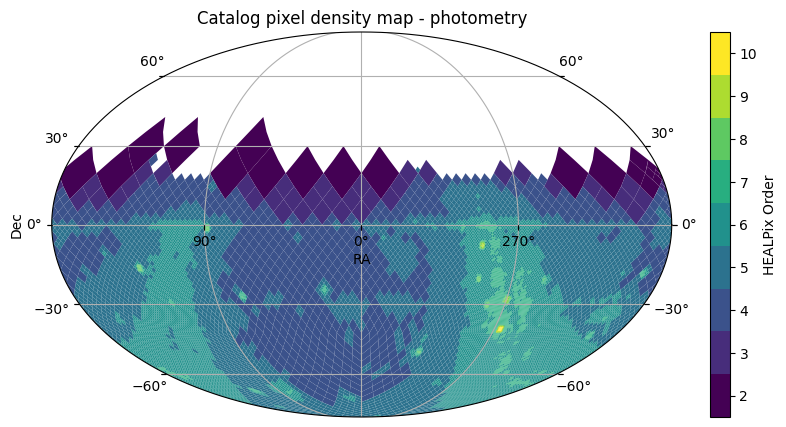

In [29]:
skymapper = hats.read_hats("/data3/epyc/data3/hats/skymapper/photometry")
skymapper.plot_pixels()

In [ ]:
"object_id_local,image_id,ccd,ra_img,decl_img,x_img,y_img,flags,nimaflags,background,flux_max,mu_max,class_star,a,e_a,b,e_b,pa,e_pa,elong,fwhm,radius_petro,radius_kron,radius_frac20,radius_frac50,radius_frac90,flux_petro,e_flux_petro,mag_petro,e_mag_petro,flux_kron,e_flux_kron,mag_kron,e_mag_kron,flux_ap02,e_flux_ap02,mag_apc02,e_mag_apc02,flux_ap03,e_flux_ap03,mag_apc03,e_mag_apc03,flux_ap04,e_flux_ap04,mag_apc04,e_mag_apc04,flux_ap05,e_flux_ap05,mag_apc05,e_mag_apc05,flux_ap06,e_flux_ap06,mag_apc06,e_mag_apc06,flux_ap08,e_flux_ap08,mag_apc08,e_mag_apc08,flux_ap10,e_flux_ap10,mag_apc10,e_mag_apc10,flux_ap15,e_flux_ap15,mag_apr15,e_mag_apr15,flux_ap20,e_flux_ap20,mag_apr20,e_mag_apr20,flux_ap30,e_flux_ap30,mag_apr30,e_mag_apr30,imaflags,x_mosaic,y_mosaic,chi2_psf,flux_psf,e_flux_psf,mag_psf,e_mag_psf,filter,img_qual,use_in_clipped,object_id".split(",")

In [30]:
import hats
from hats.pixel_math import HealpixPixel
import os

### Change this path!!!
catalog_dir = "/data3/epyc/data3/hats/skymapper/photometry"

### ----------------
### You probably won't have to change anything from here.

catalog = hats.read_hats(catalog_dir)

info_frame = catalog.partition_info.as_dataframe()

for index, partition in info_frame.iterrows():
    file_name = result = hats.io.paths.pixel_catalog_file(
        catalog_dir, HealpixPixel(partition["Norder"], partition["Npix"])
    )
#     print(file_name)
    info_frame.loc[index, "size_on_disk"] = os.path.getsize(file_name)

info_frame = info_frame.astype(int)
info_frame["gbs"] = info_frame["size_on_disk"] / (1024 * 1024 * 1024)

In [31]:
print(f'healpix orders: {info_frame["Norder"].unique()}')
print(f'num partitions: {len(info_frame["Npix"])}')
print("------")
print(f'min size_on_disk: {info_frame["gbs"].min():.2f}')
print(f'max size_on_disk: {info_frame["gbs"].max():.2f}')
print(f'size_on_disk ratio: {info_frame["gbs"].max()/info_frame["gbs"].min():.2f}')
print(f'total size_on_disk: {info_frame["gbs"].sum():.2f}')

healpix orders: [ 2  3  4  5  6  7  8  9 10]
num partitions: 16260
------
min size_on_disk: 0.00
max size_on_disk: 0.55
size_on_disk ratio: 123.48
total size_on_disk: 4156.05


In [35]:
info_frame["gbs"].idxmax()

50

In [33]:
info_frame.iloc[154]

Norder          4.000000e+00
Npix            1.100000e+03
size_on_disk    2.587413e+08
gbs             2.409716e-01
Name: 154, dtype: float64

small-ish 	: 15749 	(96.9 %)
sweet-spot 	: 511 	(3.1 %)
big-ish 	: 0 	(0.0 %)
too-big 	: 0 	(0.0 %)


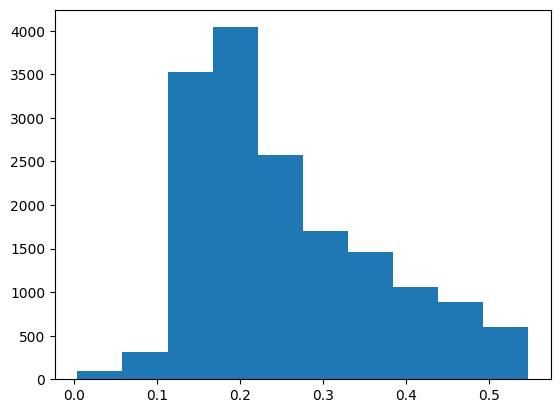

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(info_frame["gbs"])

bins = [0, 0.5, 1, 2, 100]
labels = ["small-ish", "sweet-spot", "big-ish", "too-big"]
hist = np.histogram(info_frame["gbs"], bins=bins)[0]
pcts = hist / len(info_frame)
for i in range(0, len(labels)):
    print(f"{labels[i]} \t: {hist[i]} \t({pcts[i]*100:.1f} %)")

In [40]:
import os
import pyarrow.parquet as pq
## 6/dir_20000/pixel_21738
sample_parquet_file = "/data3/epyc/data3/hats/skymapper/photometry/dataset/Norder=6/Dir=20000/Npix=21738.parquet"

sample_file_size = os.path.getsize(sample_parquet_file)
parquet_file = pq.ParquetFile(sample_parquet_file)
num_rows = parquet_file.metadata.num_rows
print("num rows", num_rows)

## 300MB
ideal_file_small = 300 * 1024 * 1024
## 1G
ideal_file_large = 1024 * 1024 * 1024

threshold_small = ideal_file_small / sample_file_size * num_rows
threshold_large = ideal_file_large / sample_file_size * num_rows

print(f"threshold between {int(threshold_small):_} and {int(threshold_large):_}")

num rows 831395
threshold between 1_061_713 and 3_623_983
